In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/project/tomatoAll.zip /content
!unzip /content/tomatoAll.zip

Streaming output truncated to the last 5000 lines.
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/253ddc99-8132-4710-bb89-eb83ab271abc___Matt.S_CG 0698.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25592188-309d-450c-b45f-fbbdb02b316f___Matt.S_CG 6181.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/2567c820-aa63-490c-8e47-921b85164728___Matt.S_CG 7447.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/256b92d9-41f3-47a4-870f-c0c0f0ac201e___Matt.S_CG 6842.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25b6cc2a-d883-4e3f-9caa-738e5ec35e30___JR_Sept.L.S 8465.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25c45a05-4f45-42ad-b18a-b7f694023a31___Matt.S_CG 0824.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25f7a39f-7fef-4f5d-af4f-cf21934f516a___JR_Sept.L.S 2493.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/261666dc-32fb-43b2-93

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/tomatoAll/'
expert_path = '/content/tomatoAll/plan-diseases-expert'
village_path = '/content/tomatoAll/plant-village'


BATCH_SIZE = 64
IMG_SIZE = (256, 256)
SEED = 42

In [3]:
train_gen, test_gen = tf.keras.utils.image_dataset_from_directory(
    village_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


VALIDATION_SPLIT = 0.15

train_gen = train_gen.take(int((1 - VALIDATION_SPLIT) * len(train_gen)))
valid_gen = train_gen.skip(int((1 - VALIDATION_SPLIT) * len(train_gen)))

test2_gen = tf.keras.utils.image_dataset_from_directory(
    expert_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test2_gen = test2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 12803 files belonging to 9 classes.
Using 10883 files for training.
Using 1920 files for validation.
Found 37455 files belonging to 9 classes.


In [4]:
from tensorflow.keras.applications import ResNet101, InceptionV3, EfficientNetB1
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
import time
import matplotlib.pyplot as plt

In [ ]:
def create_and_train_model(base_model, train_gen, test_gen, model_filename, freeze_layers=True):

    # Freeze layers
    if freeze_layers:
      for layer in base_model.layers:
          layer.trainable = False

    # GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Modify pre-trained model
    output = Dense(9, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    # model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_10e_village.model')


    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=3)

    # Save the model
    model.save(model_filename)

    # Plotting Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Measure inference time 2
    start_time = time.time()
    _, accuracy2 = model.evaluate(test2_gen)
    end_time = time.time()
    inference_time2 = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    return num_params, inference_time, accuracy, inference_time2, accuracy2


29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/50
13/13 [==============================] - 85s 970ms/step - loss: 0.6807 - accuracy: 0.7944 - val_loss: 4.8052 - val_accuracy: 0.3315
Epoch 2/50
13/13 [==============================] - 6s 473ms/step - loss: 0.0647 - accuracy: 0.9783 - val_loss: 4.3642 - val_accuracy: 0.4148
Epoch 3/50
13/13 [==============================] - 6s 472ms/step - loss: 0.0153 - accuracy: 0.9959 - val_loss: 4.3935 - val_accuracy: 0.4094
Epoch 4/50
13/13 [==============================] - 6s 472ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 2.9453 - val_accuracy: 0.4841
Epoch 5/50
13/13 [==============================] - 6s 471ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 2.3756 - val_accuracy: 0.5786
Epoch 6/50
13/13 [==============================] - 6s 473ms/step - loss: 5.4165e-04 - accuracy: 1.0000 - val_loss: 1.6069 - val_accuracy: 0.6616
Epoch 7/50
13/13 [==============================] - 6s 472ms/step - loss: 2.69

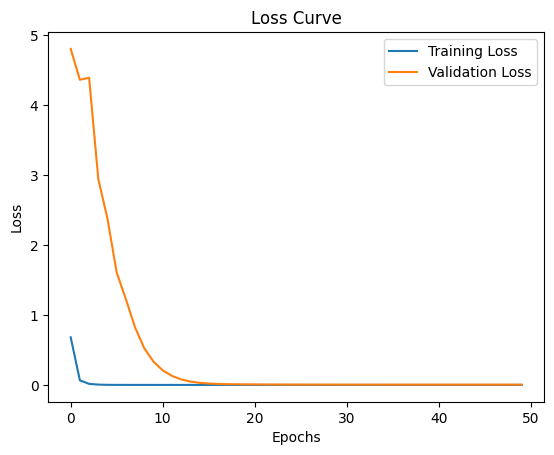

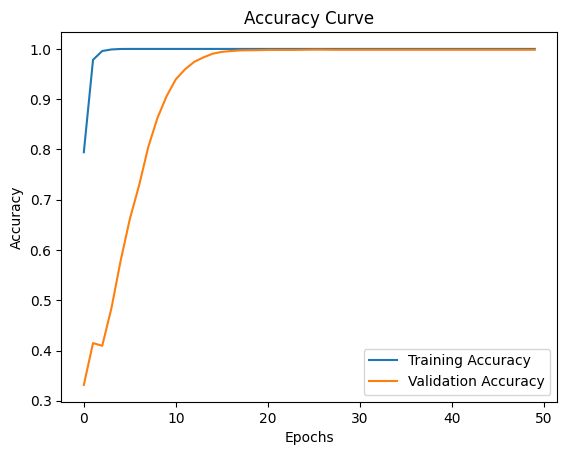

7/7 [==============================] - 2s 149ms/step - loss: 0.0108 - accuracy: 0.9973
ResNet101: Params=7046729, Time=1.1845407485961914, Accuracy=0.9919900298118591, Time2=2.1457483768463135, Accuracy2=0.9973443746566772


In [ ]:
# Create and train DenseNet121 75 2048
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, freeze_layers=False)
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/50
211/211 [==============================] - 138s 368ms/step - loss: 0.1349 - accuracy: 0.9558 - val_loss: 1.5942 - val_accuracy: 0.6951
Epoch 2/50
211/211 [==============================] - 72s 342ms/step - loss: 0.0258 - accuracy: 0.9912 - val_loss: 0.0683 - val_accuracy: 0.9763
Epoch 3/50
211/211 [==============================] - 72s 342ms/step - loss: 0.0302 - accuracy: 0.9896 - val_loss: 0.3167 - val_accuracy: 0.9106
Epoch 4/50
211/211 [==============================] - 72s 342ms/step - loss: 0.0150 - accuracy: 0.9950 - val_loss: 0.0974 - val_accuracy: 0.9641
Epoch 5/50
211/211 [==============================] - 72s 341ms/step - loss: 0.0186 - accuracy: 0.9934 - val_loss: 6.5682 - val_accuracy: 0.3674
Epoch 6/50
211/211 [==============================] - 72s 342ms/step - loss: 0.0222 - accuracy: 0.9923 - val_loss: 0.0804 - val_accuracy: 0.9688
Epoch 7/50
211/211 [==============================] - 72s 342ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0114 - val_a

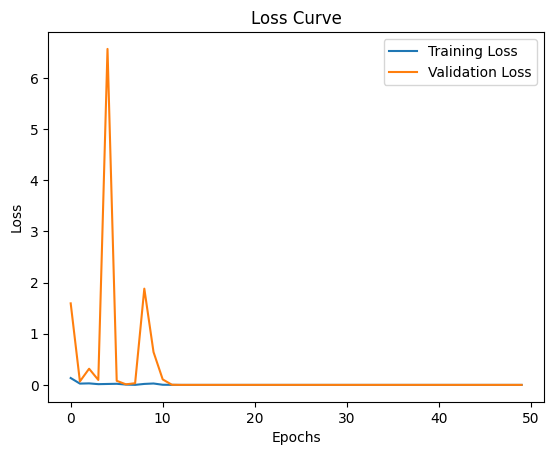

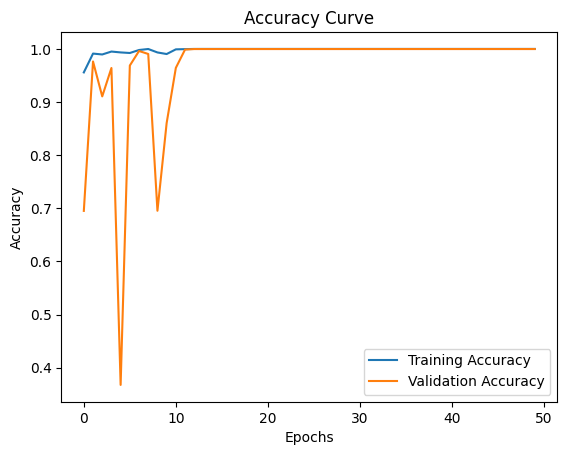

101/101 [==============================] - 12s 117ms/step - loss: 4.8061e-04 - accuracy: 0.9998
DenseNet101: Params=7046729, Time=5.3857505321502686, Accuracy=0.9998220205307007, Time2=11.96297550201416, Accuracy2=0.9998437762260437


In [ ]:
# Create and train DenseNet121 256 128
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, freeze_layers=False)
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/50
211/211 [==============================] - 144s 371ms/step - loss: 0.1292 - accuracy: 0.9568 - val_loss: 0.5350 - val_accuracy: 0.8599
Epoch 2/50
211/211 [==============================] - 73s 345ms/step - loss: 0.0383 - accuracy: 0.9878 - val_loss: 1.6468 - val_accuracy: 0.7048
Epoch 3/50
211/211 [==============================] - 73s 345ms/step - loss: 0.0206 - accuracy: 0.9936 - val_loss: 1.4410 - val_accuracy: 0.6367
Epoch 4/50
211/211 [==============================] - 73s 345ms/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.5865 - val_accuracy: 0.8667
Epoch 5/50
211/211 [==============================] - 73s 344ms/step - loss: 0.0173 - accuracy: 0.9947 - val_loss: 0.4771 - val_accuracy: 0.8816
Epoch 6/50
211/211 [==============================] - 73s 344ms/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.0343 - val_accuracy: 0.9878
Epoch 7/50
211/211 [==============================] - 73s 344ms/step - loss: 0.0130 - accuracy: 0.9959 - val_loss: 1.2745 - val_a

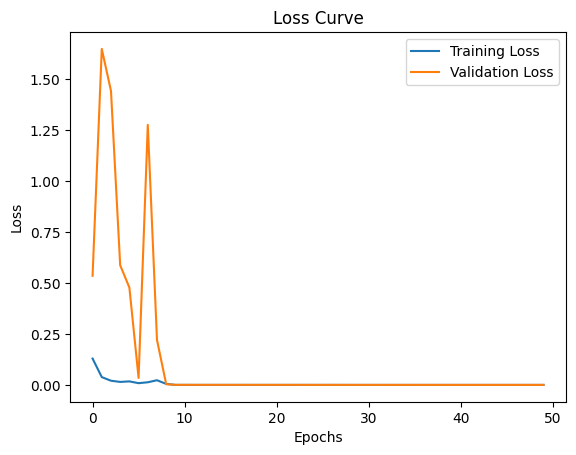

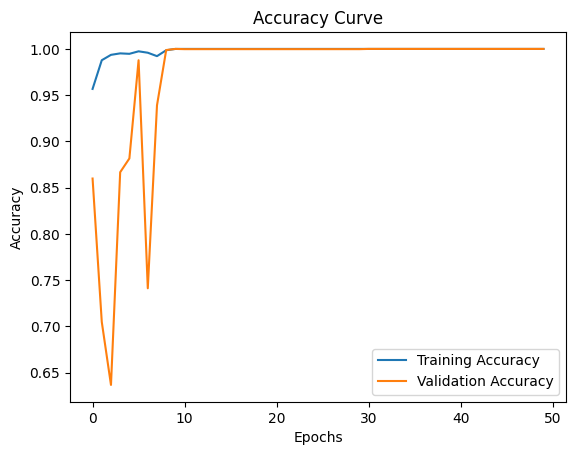

101/101 [==============================] - 12s 117ms/step - loss: 2.6741e-04 - accuracy: 0.9998
DenseNet101: Params=7046729, Time=5.405210733413696, Accuracy=0.9996439814567566, Time2=11.984914779663086, Accuracy2=0.9998437762260437


In [ ]:
# Create and train DenseNet121 256 128  saved
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_50e.model',freeze_layers=False)
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/10
211/211 [==============================] - 127s 353ms/step - loss: 0.1335 - accuracy: 0.9542 - val_loss: 0.5280 - val_accuracy: 0.8811
Epoch 2/10
211/211 [==============================] - 73s 344ms/step - loss: 0.0291 - accuracy: 0.9906 - val_loss: 0.0733 - val_accuracy: 0.9739
Epoch 3/10
211/211 [==============================] - 73s 345ms/step - loss: 0.0271 - accuracy: 0.9913 - val_loss: 0.0542 - val_accuracy: 0.9810
Epoch 4/10
211/211 [==============================] - 73s 344ms/step - loss: 0.0198 - accuracy: 0.9939 - val_loss: 0.2616 - val_accuracy: 0.9119
Epoch 5/10
211/211 [==============================] - 73s 344ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 0.1175 - val_accuracy: 0.9668
Epoch 6/10
211/211 [==============================] - 73s 344ms/step - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.0608 - val_accuracy: 0.9810
Epoch 7/10
211/211 [==============================] - 73s 344ms/step - loss: 0.0357 - accuracy: 0.9874 - val_loss: 1.1982 - val_a

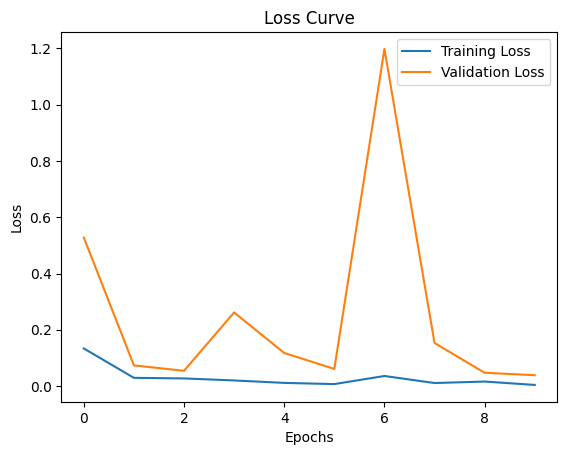

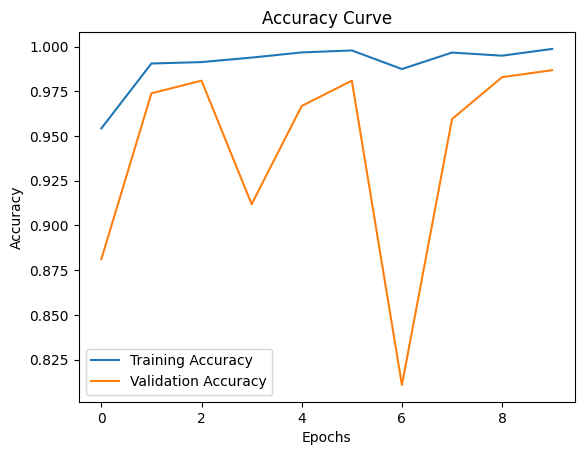

101/101 [==============================] - 12s 119ms/step - loss: 0.0443 - accuracy: 0.9851
DenseNet101: Params=7046729, Time=5.499880790710449, Accuracy=0.9809540510177612, Time2=12.192858457565308, Accuracy2=0.9850816130638123


In [ ]:
# Create and train DenseNet121 256 128  saved  10epoch
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_10e.model',freeze_layers=False)
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/10
145/145 [==============================] - 101s 305ms/step - loss: 0.2536 - accuracy: 0.9126 - val_loss: 3.1659 - val_accuracy: 0.4737
Epoch 2/10
145/145 [==============================] - 40s 279ms/step - loss: 0.0689 - accuracy: 0.9758 - val_loss: 0.2656 - val_accuracy: 0.9183
Epoch 3/10
145/145 [==============================] - 40s 279ms/step - loss: 0.0305 - accuracy: 0.9906 - val_loss: 0.2351 - val_accuracy: 0.9077
Epoch 4/10
145/145 [==============================] - 40s 279ms/step - loss: 0.0464 - accuracy: 0.9844 - val_loss: 0.1372 - val_accuracy: 0.9538
Epoch 5/10
145/145 [==============================] - 40s 279ms/step - loss: 0.0356 - accuracy: 0.9887 - val_loss: 0.8765 - val_accuracy: 0.7912
Epoch 6/10
145/145 [==============================] - 40s 279ms/step - loss: 0.0301 - accuracy: 0.9904 - val_loss: 0.3266 - val_accuracy: 0.8977
Epoch 7/10
145/145 [==============================] - 40s 279ms/step - loss: 0.0134 - accuracy: 0.9964 - val_loss: 0.5414 - val_a

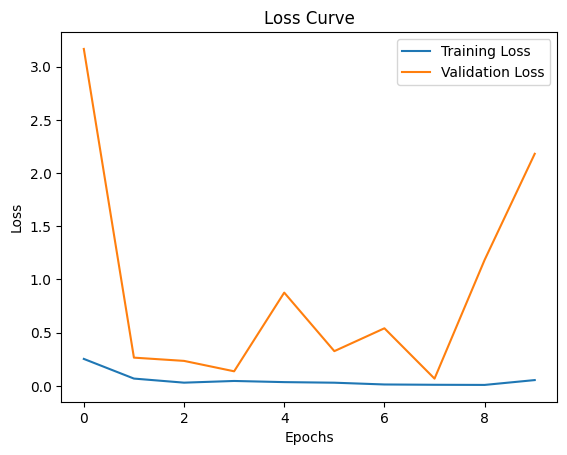

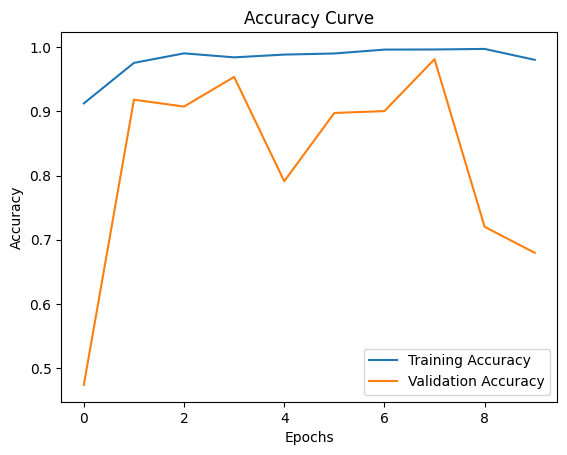

559/586 [===========================>..] - ETA: 2s - loss: 3.0058 - accuracy: 0.5940

In [ ]:
# Create and train DenseNet121 256 128  saved  10epoch village
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_10e_village.model',freeze_layers=False)
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/10
145/145 [==============================] - 94s 295ms/step - loss: 0.0556 - accuracy: 0.9819 - val_loss: 0.7902 - val_accuracy: 0.8359
Epoch 2/10
145/145 [==============================] - 41s 282ms/step - loss: 0.0247 - accuracy: 0.9919 - val_loss: 1.2880 - val_accuracy: 0.7805
Epoch 3/10
145/145 [==============================] - 41s 282ms/step - loss: 0.0387 - accuracy: 0.9873 - val_loss: 0.0971 - val_accuracy: 0.9609
Epoch 4/10
145/145 [==============================] - 41s 282ms/step - loss: 0.0333 - accuracy: 0.9890 - val_loss: 1.8118 - val_accuracy: 0.6122
Epoch 5/10
145/145 [==============================] - 41s 282ms/step - loss: 0.0223 - accuracy: 0.9935 - val_loss: 0.0547 - val_accuracy: 0.9822
Epoch 6/10
145/145 [==============================] - 41s 281ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0531 - val_accuracy: 0.9808
Epoch 7/10
145/145 [==============================] - 41s 281ms/step - loss: 7.1632e-04 - accuracy: 1.0000 - val_loss: 3.9036e-04 

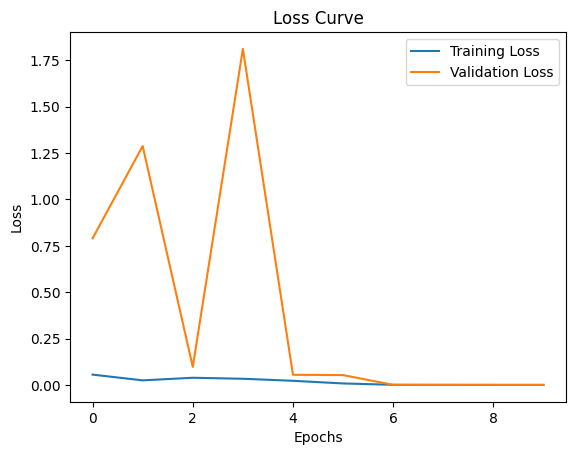

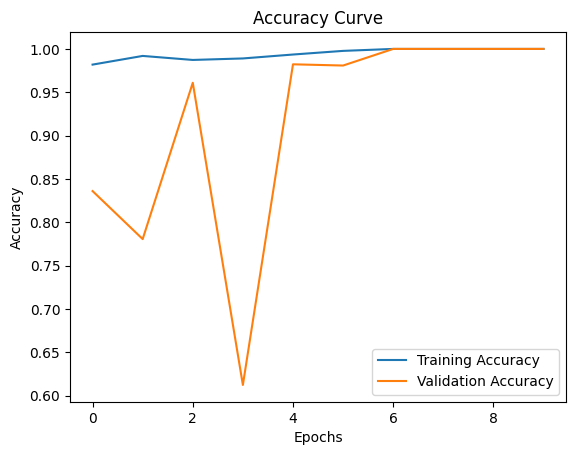

586/586 [==============================] - 50s 85ms/step - loss: 0.1087 - accuracy: 0.9731
DenseNet101: Params=7046729, Time=2.6052422523498535, Accuracy=0.9973958134651184, Time2=49.664663314819336, Accuracy2=0.9731144309043884


In [ ]:
# Create and train DenseNet121 256 128  saved  10-20epoch village
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_20e_village.model',freeze_layers=False)
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/10
145/145 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.9176

145/145 [==============================] - 100s 328ms/step - loss: 0.2397 - accuracy: 0.9176 - val_loss: 2.4284 - val_accuracy: 0.6456
Epoch 2/10
145/145 [==============================] - 41s 281ms/step - loss: 0.0658 - accuracy: 0.9773 - val_loss: 0.9841 - val_accuracy: 0.7876
Epoch 3/10
145/145 [==============================] - 41s 281ms/step - loss: 0.0794 - accuracy: 0.9734 - val_loss: 1.0299 - val_accuracy: 0.7514
Epoch 4/10
145/145 [==============================] - 41s 281ms/step - loss: 0.0452 - accuracy: 0.9855 - val_loss: 1.2952 - val_accuracy: 0.8494
Epoch 5/10
145/145 [==============================] - 41s 281ms/step - loss: 0.0191 - accuracy: 0.9945 - val_loss: 0.1161 - val_accuracy: 0.9695
Epoch 6/10
145/145 [==============================] - 41s 281ms/step - loss: 0.0126 - accuracy: 0.9966 - val_loss: 0.0764 - val_accuracy: 0.9680
Epoch 7/10
145/145 [==============================] - 41s 282ms/step - loss: 0.0237 - accuracy: 0.9925 - val_loss: 0.6163 - val_accuracy: 0.

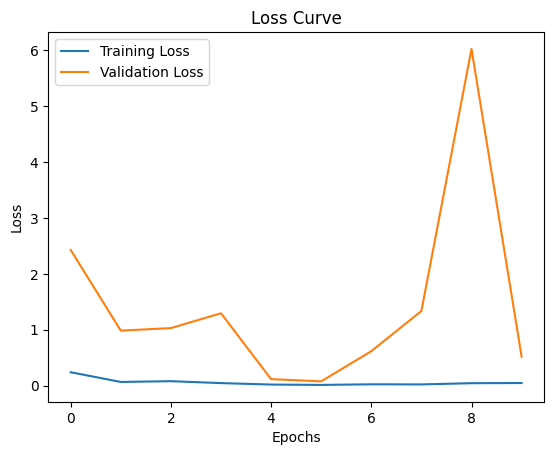

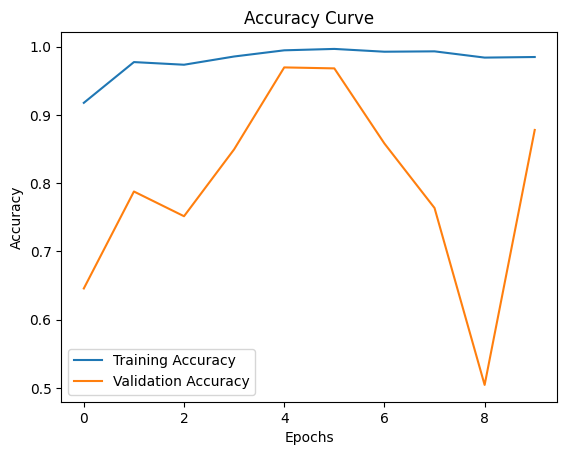

586/586 [==============================] - 50s 85ms/step - loss: 0.8306 - accuracy: 0.8109
DenseNet101: Params=7046729, Time=2.718824625015259, Accuracy=0.8807291388511658, Time2=50.02352213859558, Accuracy2=0.8108663558959961


In [ ]:
# Create and train DenseNet121 256 128  saved  6epoch village
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_6e_village.model',freeze_layers=False)
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/6
145/145 [==============================] - 94s 295ms/step - loss: 0.2384 - accuracy: 0.9186 - val_loss: 3.6989 - val_accuracy: 0.4503
Epoch 2/6
145/145 [==============================] - 41s 281ms/step - loss: 0.0622 - accuracy: 0.9794 - val_loss: 0.1231 - val_accuracy: 0.9524
Epoch 3/6
145/145 [==============================] - 41s 281ms/step - loss: 0.0504 - accuracy: 0.9827 - val_loss: 6.4781 - val_accuracy: 0.4460
Epoch 4/6
145/145 [==============================] - 41s 281ms/step - loss: 0.0510 - accuracy: 0.9841 - val_loss: 2.1994 - val_accuracy: 0.6364
Epoch 5/6
145/145 [==============================] - 41s 281ms/step - loss: 0.0263 - accuracy: 0.9906 - val_loss: 0.0714 - val_accuracy: 0.9780
Epoch 6/6
145/145 [==============================] - 41s 280ms/step - loss: 0.0256 - accuracy: 0.9908 - val_loss: 0.1589 - val_accuracy: 0.9510


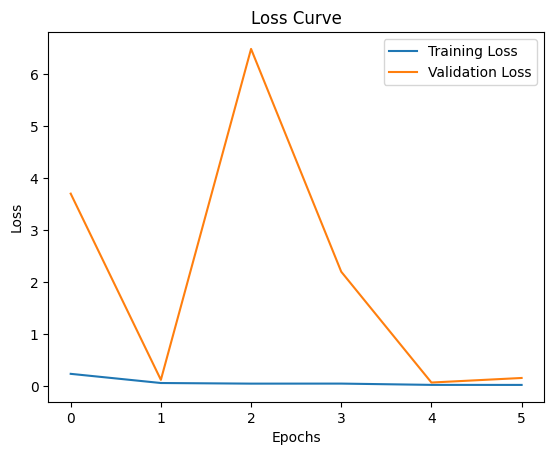

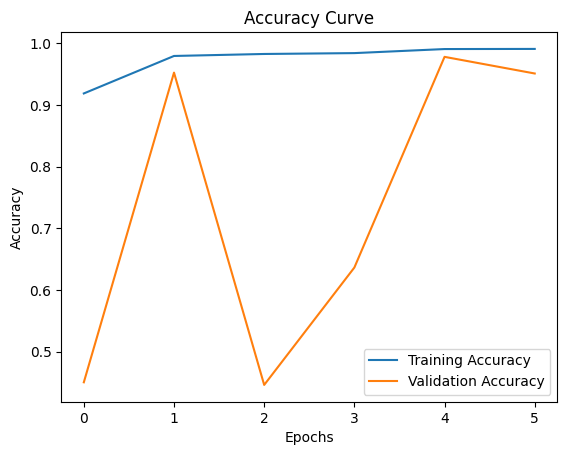

586/586 [==============================] - 49s 84ms/step - loss: 0.7376 - accuracy: 0.8424
DenseNet101: Params=7046729, Time=2.58178973197937, Accuracy=0.9281250238418579, Time2=49.388590574264526, Accuracy2=0.8423975706100464


In [ ]:
# Create and train DenseNet121 256 128  saved  6epoch village
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_66e_village.model',freeze_layers=False)
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/3
145/145 [==============================] - 99s 298ms/step - loss: 0.2676 - accuracy: 0.9105 - val_loss: 5.7890 - val_accuracy: 0.4496
Epoch 2/3
145/145 [==============================] - 41s 283ms/step - loss: 0.0744 - accuracy: 0.9765 - val_loss: 0.9597 - val_accuracy: 0.7983
Epoch 3/3
145/145 [==============================] - 41s 283ms/step - loss: 0.0360 - accuracy: 0.9886 - val_loss: 0.8335 - val_accuracy: 0.8153


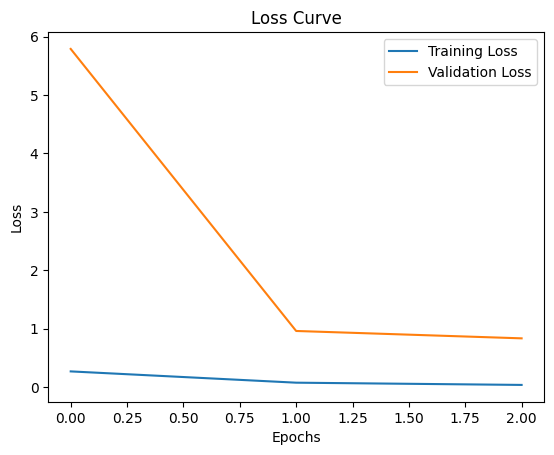

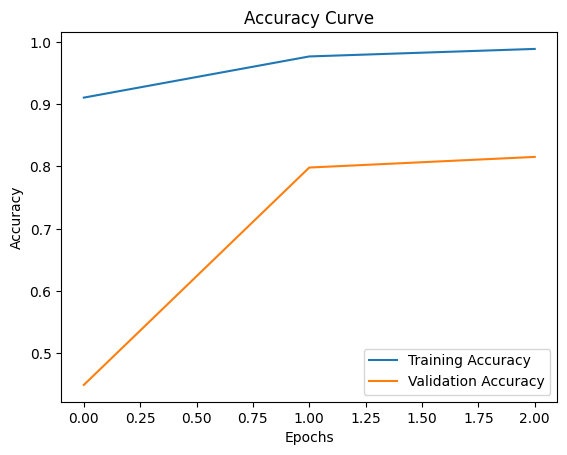

586/586 [==============================] - 50s 85ms/step - loss: 1.5286 - accuracy: 0.7072
DenseNet101: Params=7046729, Time=2.5998783111572266, Accuracy=0.8067708611488342, Time2=49.55769467353821, Accuracy2=0.7071685791015625


In [ ]:
# Create and train DenseNet121 256 128  saved  3epoch village
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_3e_village.model',freeze_layers=False)
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

In [5]:
test3_gen = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/tomato_images2/',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)
class_names = test3_gen.class_names

print(test3_gen.class_names)


Found 35 files belonging to 9 classes.
['Tomato Bacterial spot', 'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Spider mites Two spotted spider mite', 'Tomato Target Spot', 'Tomato Tomato mosaic virus', 'Tomato healthy']


In [6]:
# prompt: load_model from the path

model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_6e_village.model')
# prompt: load_model from the path

model2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_20e_argu.model')


In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Define constants (assuming these are defined in the user's environment)
IMG_SIZE = (256, 256)
BATCH_SIZE = 128


# Get the class names and find the index of 'healthy' class
class_names = test3_gen.class_names
healthy_index = class_names.index('Tomato healthy')

# Get the predictions from the model
predictions = model.predict(test3_gen, verbose=1)

# Convert predictions to binary (healthy vs unhealthy)
healthy_predictions = predictions[:, healthy_index]
unhealthy_predictions = 1 - healthy_predictions

# Collect all test images and their true labels
all_test_images = []
all_true_labels = []
for images, labels in test3_gen:
    all_test_images.extend(images)
    # print(labels)
    all_true_labels.extend(np.argmax(labels, axis=1))

# Convert to numpy arrays for easier manipulation
all_test_images = np.array(all_test_images)
all_true_labels = np.array(all_true_labels)
healthy_labels = (all_true_labels == healthy_index).astype(int)

# Calculate ROC curve and AUC for 'healthy' class
fpr, tpr, _ = roc_curve(healthy_labels, healthy_predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Healthy Class')
plt.legend(loc="lower right")
plt.show()


ResourceExhaustedError: ignored

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(healthy_labels, healthy_predictions)
average_precision = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (area = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for "Healthy" Class')
plt.legend(loc="best")
plt.show()


1/1 [==============================] - 0s 385ms/step
[4 4 0 0 1 2 4 1 2 2 2 2 2 2 2 4 1 1 2 5 1 1 1 2 6 7 7 2 7 4 4 8 1 8 2]
['Tomato Bacterial spot', 'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Spider mites Two spotted spider mite', 'Tomato Target Spot', 'Tomato Tomato mosaic virus', 'Tomato healthy']


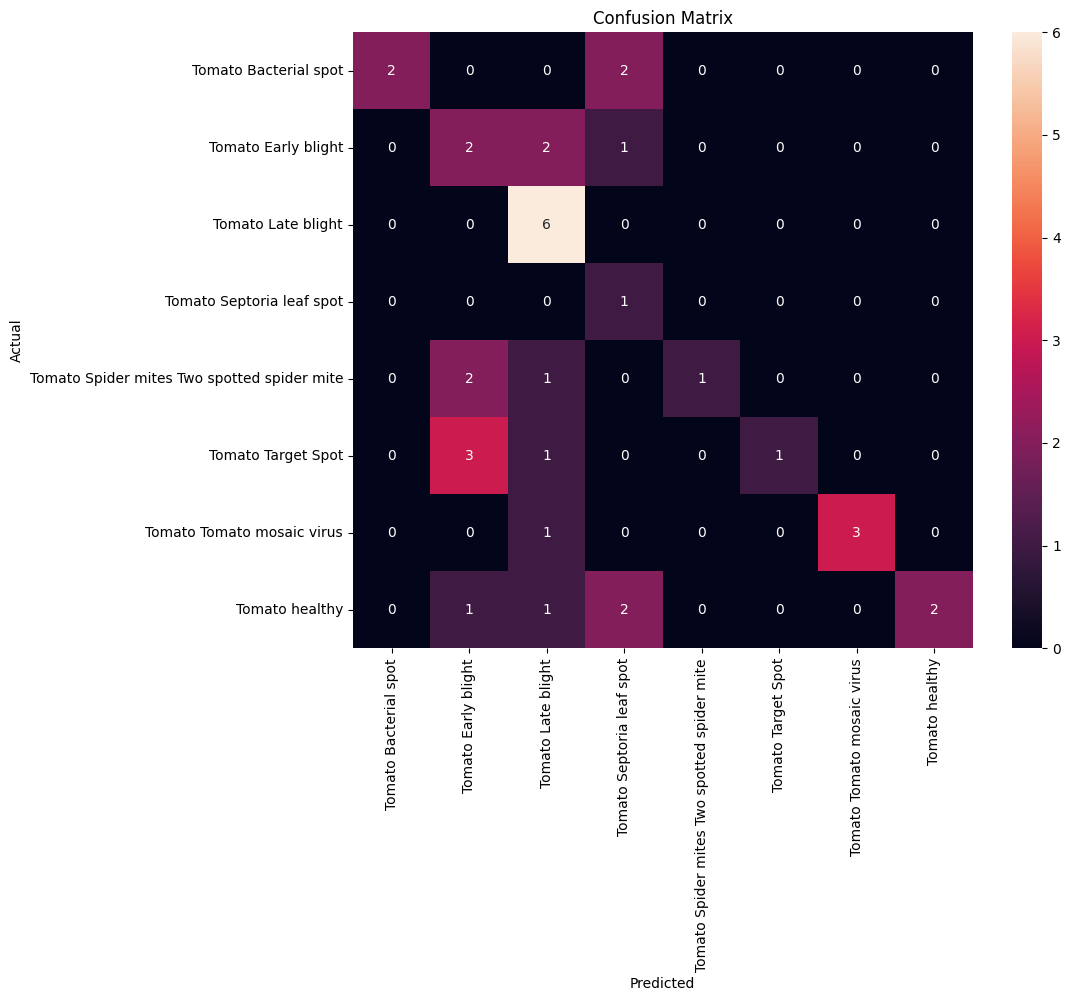

Tomato Bacterial spot: Correct = 2, Incorrect = 2
Tomato Early blight: Correct = 2, Incorrect = 3
Tomato Late blight: Correct = 6, Incorrect = 0
Tomato Leaf Mold: Correct = 0, Incorrect = 0
Tomato Septoria leaf spot: Correct = 1, Incorrect = 0
Tomato Spider mites Two spotted spider mite: Correct = 1, Incorrect = 3
Tomato Target Spot: Correct = 1, Incorrect = 4
Tomato Tomato mosaic virus: Correct = 3, Incorrect = 1
Tomato healthy: Correct = 2, Incorrect = 4


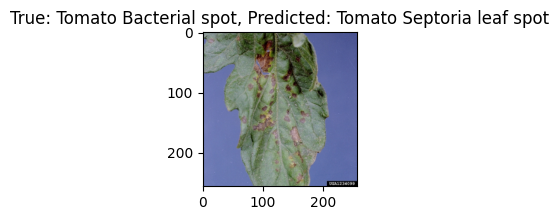

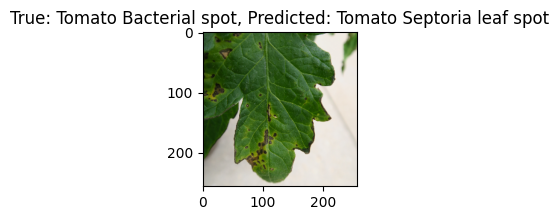

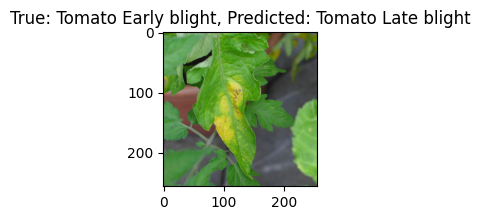

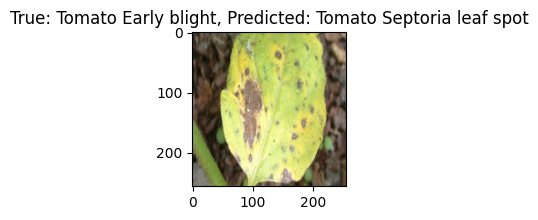

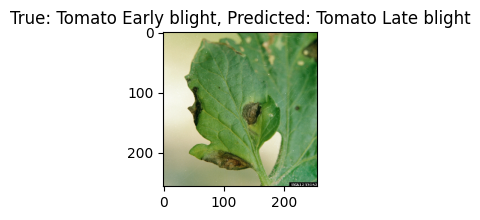

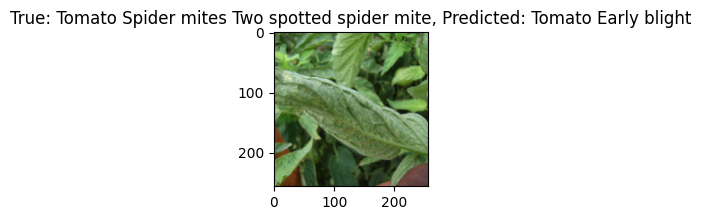

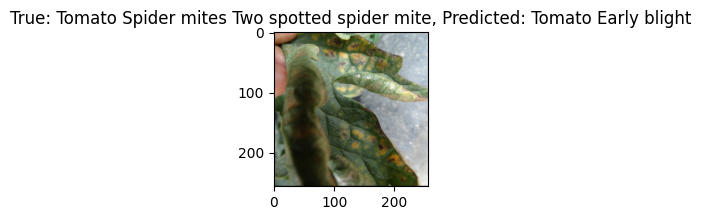

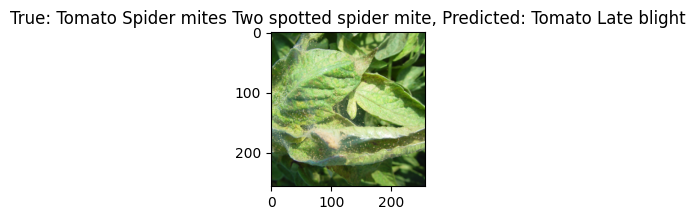

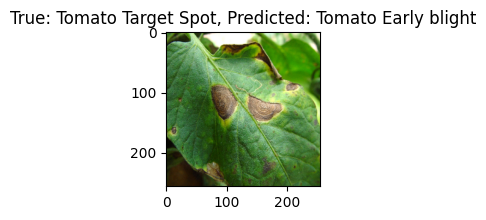

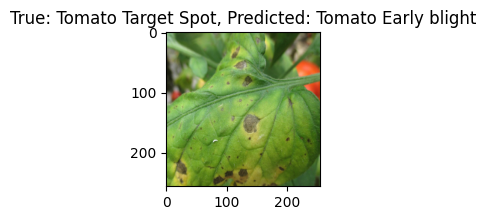

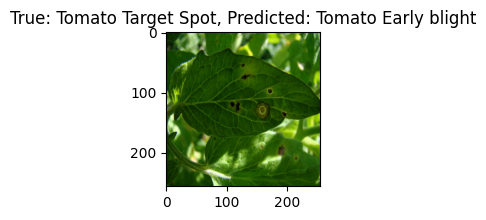

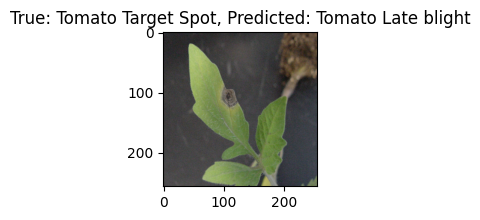

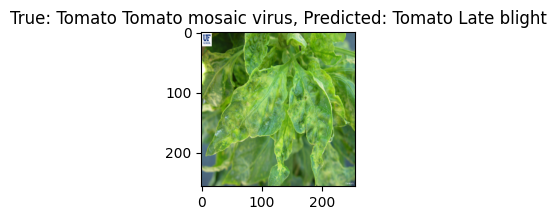

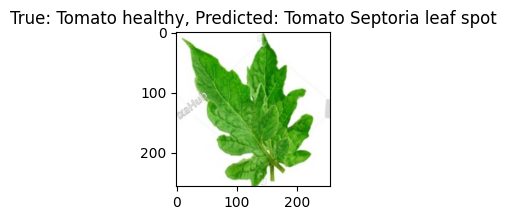

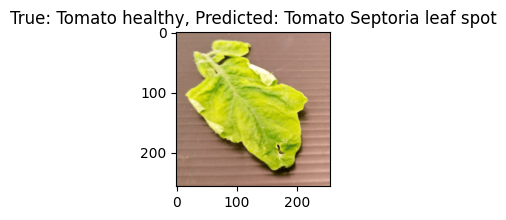

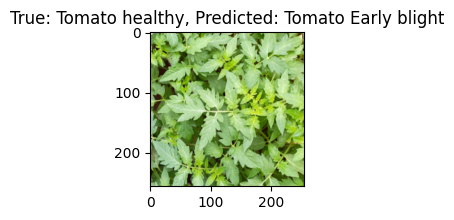

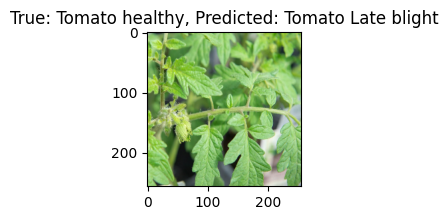

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect all test images and their true labels
all_test_images = []
all_true_labels = []
for images, labels in test3_gen:
    all_test_images.extend(images)
    # print(labels)
    all_true_labels.extend(np.argmax(labels, axis=1))

# Convert to numpy arrays for easier manipulation
all_test_images = np.array(all_test_images)
all_true_labels = np.array(all_true_labels)

# Predict labels for the test set
model.evaluate(test3_gen)
predicted = model.predict(test3_gen)
predicted_labels = np.argmax(predicted, axis=1)

# Ensure the arrays are of the same length
min_length = min(len(all_true_labels), len(predicted_labels))
all_true_labels = all_true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]

print(predicted_labels)
print(class_names)

# Plotting the confusion matrix

a = all_true_labels.copy()
a[a > 3] -= 1
p = predicted_labels.copy()
p[p > 3] -= 1
cm = confusion_matrix(a, p)
plt.figure(figsize=(10, 8))
c = class_names.copy()
c.pop(3)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=c, yticklabels=c)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Find indices of misclassified images
misclassified_indices = np.where(predicted_labels != all_true_labels)[0]


# Initialize counters for correct and incorrect predictions
correct_counts = {class_name: 0 for class_name in class_names}
incorrect_counts = {class_name: 0 for class_name in class_names}

# Iterate over all predictions and update counts
for true_label, predicted_label in zip(all_true_labels, predicted_labels):
    if true_label == predicted_label:
        correct_counts[class_names[true_label]] += 1
    else:
        incorrect_counts[class_names[true_label]] += 1

# Print the counts
for class_name in class_names:
    print(f"{class_name}: Correct = {correct_counts[class_name]}, Incorrect = {incorrect_counts[class_name]}")



# Plot a few misclassified images
num_images_to_show = 1000  # Adjust as needed
for i in misclassified_indices[:num_images_to_show]:
    plt.figure(figsize=(2, 2))
    plt.imshow(all_test_images[i].astype("uint8"))
    true_label_name = class_names[all_true_labels[i]]
    predicted_label_name = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label_name}, Predicted: {predicted_label_name}")
    plt.show()


1/1 [==============================] - 7s 7s/step


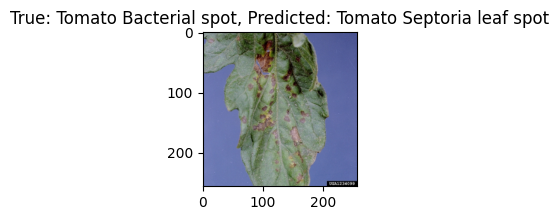

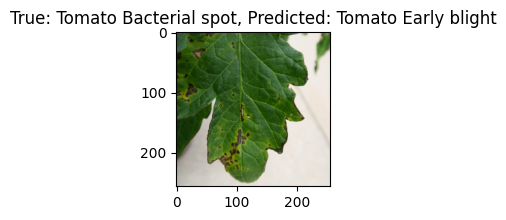

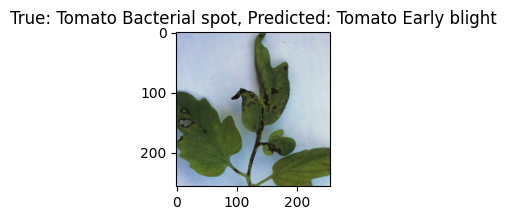

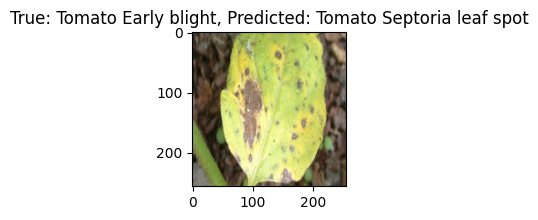

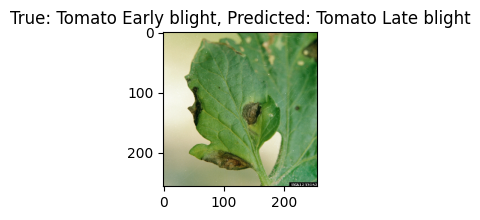

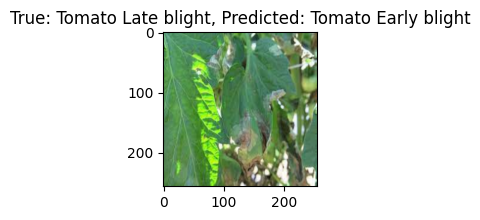

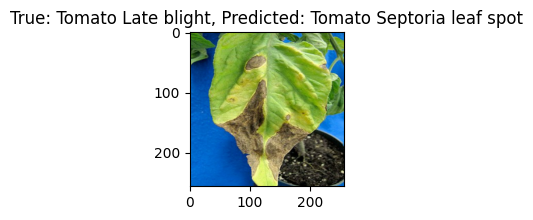

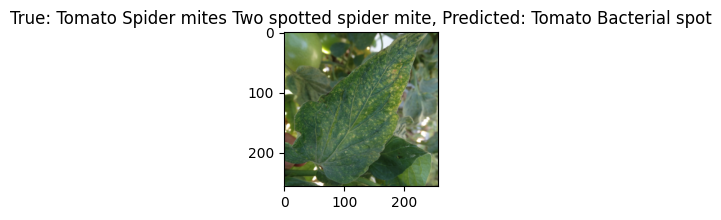

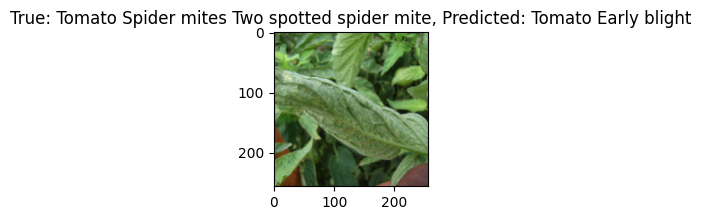

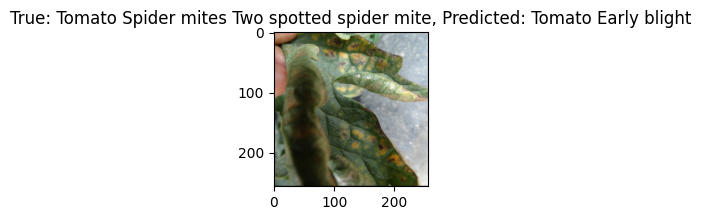

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all test images and their true labels
all_test_images = []
all_true_labels = []
for images, labels in test3_gen:
    all_test_images.extend(images)
    # print(labels)
    all_true_labels.extend(np.argmax(labels, axis=1))

# Convert to numpy arrays for easier manipulation
all_test_images = np.array(all_test_images)
all_true_labels = np.array(all_true_labels)

# Predict labels for the test set
model2.evaluate(test3_gen)
predicted = model2.predict(test3_gen)
predicted_labels = np.argmax(predicted, axis=1)

# Ensure the arrays are of the same length
min_length = min(len(all_true_labels), len(predicted_labels))
all_true_labels = all_true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]

# print(predicted_labels)

# Find indices of misclassified images
misclassified_indices = np.where(predicted_labels != all_true_labels)[0]

# Plot a few misclassified images
num_images_to_show = 10  # Adjust as needed
for i in misclassified_indices[:num_images_to_show]:
    plt.figure(figsize=(2, 2))
    plt.imshow(all_test_images[i].astype("uint8"))
    true_label_name = class_names[all_true_labels[i]]
    predicted_label_name = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label_name}, Predicted: {predicted_label_name}")
    plt.show()
